# Intelligent Control (ECE-DK807)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 6

### Cartpole System

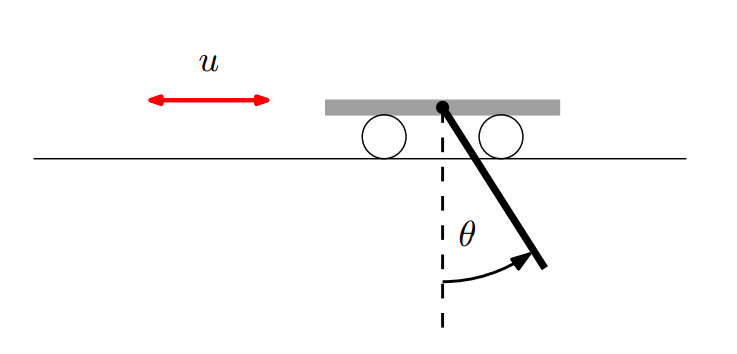

The cartpole system consists of a cart with mass $m_1$ and an attached pendulum with mass $m_2$ and length $l_p$, which swings freely in the plane.

The state of the system is $\boldsymbol{x} = \begin{bmatrix}x\\\theta\\\dot{x}\\\dot{\theta}\end{bmatrix}\in\mathbb{R}^4$ and the control input $\boldsymbol{u} = \tau\in\mathbb{R}$ is the horizontal force applied to the cart.

The dynamics are given by the following equation:

$\dot{\boldsymbol{x}} = f(\boldsymbol{x}, \boldsymbol{u}) = \begin{bmatrix}\dot{x}\\\dot{\theta}\\\frac{2m_2l_p\dot{\theta}^2\sin\theta + 3m_2g\sin\theta\cos\theta + 4\tau - 4b_f\dot{x}}{4(m_1+m_2) - 3m_2\cos^2\theta}\\\frac{-3m_2l_p\dot{\theta}^2\sin\theta\cos\theta - 6(m_1+m_2)g\sin\theta - 6(\tau-b_f\dot{x})\cos\theta}{4l_p(m_1+m_2)-3m_2l_p\cos^2\theta}\end{bmatrix}$

Let's first write down the dynamics!

In [1]:
# Let's first import modules
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
import copy
import random
from collections import deque
import torch # neural networks (auto-diff)
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Dynamics
def cartpole_dynamics(xx, uu):
    m1 = 0.5 # cart
    m2 = 0.5 # pole
    lp = 0.6 # length pole
    bf = 0.1 # friction
    g = 9.81 # gravity

    x = xx.reshape((4,))
    u = uu.reshape((1,))[0]

    ### TO-DO: Write the dynamics equations
    ### X = [x,θ,\dot{x},\dot{θ}]
    ### Use numpy and not pytorch for this. You should return a numpy array of size 4x1 that holds \dot{X}.
    ### ANSWER: Insert code here
    theta = x[1]
    x_dot = x[2]
    theta_dot = x[3]

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    theta_dot_square = theta_dot * theta_dot
    
    temp1 = 2*m2*lp*theta_dot_square*sin_theta + 3*m2*g*sin_theta*cos_theta + 4*u - 4*bf*x_dot
    temp2 = -3*m2*lp*theta_dot_square*sin_theta*cos_theta - 6*(m1+m2)*g*sin_theta - 6*(u-bf*x_dot)*cos_theta
    temp3 = 4*(m1+m2) - 3*m2*cos_theta*cos_theta

    x_dot_dot = temp1 / temp3
    theta_dot_dot = temp2 / (lp * temp3)

    dΧ = np.array([x_dot, theta_dot, x_dot_dot, theta_dot_dot])
    
    return dΧ.reshape((4, 1));
    ### END of ANSWER

def cartpole_rk4(x, u, dt = 0.05):
    f1 = cartpole_dynamics(x, u)
    f2 = cartpole_dynamics(x + 0.5 * dt * f1, u)
    f3 = cartpole_dynamics(x + 0.5 * dt * f2, u)
    f4 = cartpole_dynamics(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

In [3]:
x0 = np.zeros((4, 1))
u0 = np.zeros((1, 1))

assert(cartpole_dynamics(x0, u0).shape == (4, 1))
assert(np.isclose(cartpole_dynamics(x0, u0), np.zeros((4, 1))).all())

x0[1, 0] = np.pi
assert(np.isclose(cartpole_dynamics(x0, u0), np.zeros((4, 1))).all())

x0[1, 0] = np.pi / 2.
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[0., 0., 0., -24.525]]).T, rtol=1e-3).all())

x0[1, 0] = -np.pi / 2.
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[0., 0., 0., 24.525]]).T, rtol=1e-3).all())

x0 = np.zeros((4, 1))
u0 = np.ones((1, 1))
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[0., 0., 1.6, -4.]]).T, rtol=1e-3).all())

u0 = -np.ones((1, 1))
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[0., 0., -1.6, 4.]]).T, rtol=1e-3).all())

x0 = np.zeros((4, 1))
x0[2, 0] = 1.
x0[3, 0] = 1.
u0 = np.zeros((1, 1))
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[1., 1., -0.16, 0.4]]).T, rtol=1e-3).all())

x0 = np.zeros((4, 1))
x0[2, 0] = -1.
x0[3, 0] = -1.
u0 = np.zeros((1, 1))
assert(np.isclose(cartpole_dynamics(x0, u0), np.array([[-1., -1., 0.16, -0.4]]).T, rtol=1e-3).all())


In [4]:
# A few helpers
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

### Replay/Experience Buffer

We now want to create a **Replay Buffer** that holds tuples of the form `(state, action, next_state, reward, done)`. This is crucial for being able to train more efficiently!

Let's do this!

In [5]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.idx = 0
        self.size = 0
        
        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def add(self, state, action, next_state, reward, done):
        '''
        ### TO-DO: Add new tuple into the replay buffer! Make sure to update the current index (idx) and size correctly!
        ### When the index reaches the max capacity limit, we want to start it from the beginning
        ### We are still working in numpy here!
        ### state is a (state_dim,) numpy array
        ### action is a (action_dim,) numpy array)
        ### next_state is a (state_dim,) numpy array
        ### reward is a scalar
        ### done is a scalar
        '''
        
        ### ANSWER: Insert code here        
        self.state[self.idx] = state
        self.action[self.idx] = action
        self.next_state[self.idx] = next_state
        self.reward[self.idx] = reward
        self.not_done[self.idx] = not done

        self.idx += 1
        self.idx = self.idx % self.max_size
        self.size += 1 if self.size < self.max_size else 0

        return;
        ### END of ANSWER

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

In [6]:
Nx = 3
Nu = 2
max_size = 2

my_buffer = ReplayBuffer(Nx, Nu, max_size)

s0 = np.random.randn(Nx)
u0 = np.random.randn(Nu)
s1 = np.random.randn(Nx)
r0 = np.random.randn(1)[0]
d0 = 0. if np.random.random() > 0.5 else 1.

# s1 = np.random.randn(Nx)
u1 = np.random.randn(Nu)
s2 = np.random.randn(Nx)
r1 = np.random.randn(1)[0]
d1 = 0. if np.random.random() > 0.5 else 1.

my_buffer.add(s0, u0, s1, r0, d0)
assert(my_buffer.idx == 1)
assert(my_buffer.size == 1)

assert(np.isclose(my_buffer.state[my_buffer.idx - 1], s0, rtol=1e-3).all())
assert(np.isclose(my_buffer.action[my_buffer.idx - 1], u0, rtol=1e-3).all())
assert(np.isclose(my_buffer.next_state[my_buffer.idx - 1], s1, rtol=1e-3).all())
assert(np.isclose(my_buffer.reward[my_buffer.idx - 1], r0, rtol=1e-3).all())
assert(np.isclose(my_buffer.not_done[my_buffer.idx - 1], 1. - d0, rtol=1e-3).all())

my_buffer.add(s1, u1, s2, r1, d1)
assert(my_buffer.idx == 0)
assert(my_buffer.size == 2)

assert(np.isclose(my_buffer.state[my_buffer.idx - 1], s1, rtol=1e-3).all())
assert(np.isclose(my_buffer.action[my_buffer.idx - 1], u1, rtol=1e-3).all())
assert(np.isclose(my_buffer.next_state[my_buffer.idx - 1], s2, rtol=1e-3).all())
assert(np.isclose(my_buffer.reward[my_buffer.idx - 1], r1, rtol=1e-3).all())
assert(np.isclose(my_buffer.not_done[my_buffer.idx - 1], 1. - d1, rtol=1e-3).all())

my_buffer.add(s1, u1, s2, r1, d1)
assert(my_buffer.idx == 1)
assert(my_buffer.size == 2)

for idx in range(2):
    assert(np.isclose(my_buffer.state[idx], s1, rtol=1e-3).all())
    assert(np.isclose(my_buffer.action[idx], u1, rtol=1e-3).all())
    assert(np.isclose(my_buffer.next_state[idx], s2, rtol=1e-3).all())
    assert(np.isclose(my_buffer.reward[idx], r1, rtol=1e-3).all())
    assert(np.isclose(my_buffer.not_done[idx], 1. - d1, rtol=1e-3).all())

### TD3 Algorithm!

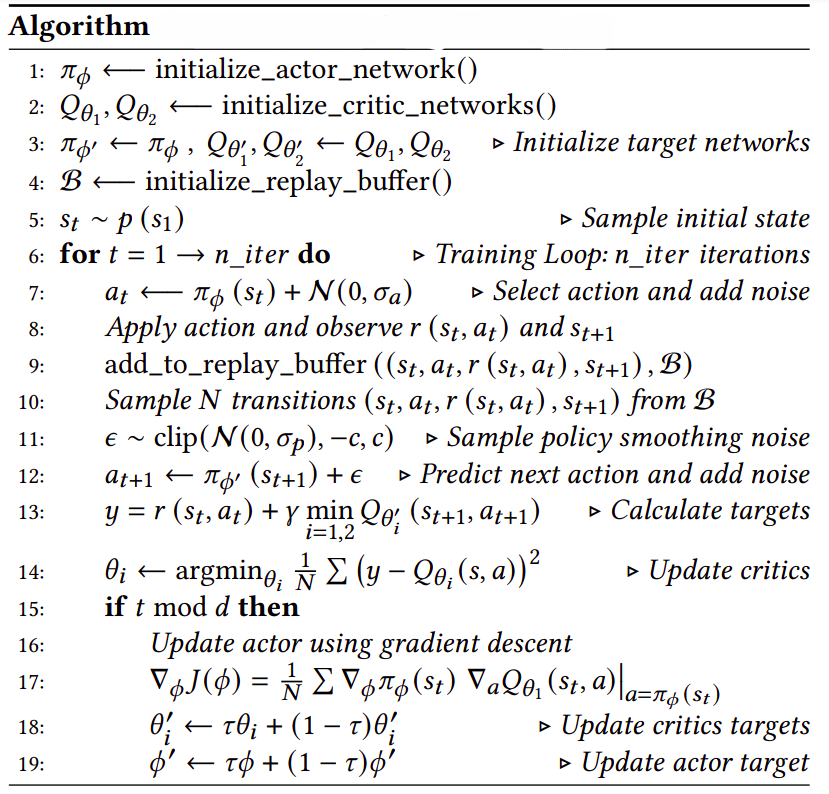

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Twin Delayed Deep Deterministic Policy Gradients (TD3)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        ### TO-DO: Let's create a feedforward neural network with 2 hidden layers with 256 neurons!
        ### ANSWER: Insert code here
        self.linear1 = torch.nn.Linear(state_dim, 256)
        self.linear2 = torch.nn.Linear(256, 256)
        self.linear3 = torch.nn.Linear(256, action_dim)
        ### END of ANSWER
        
        self.max_action = max_action

    
    def forward(self, state):
        ### TO-DO: Implement forward! 
        ### Let's use ReLU in the hidden layers and tanh at the output!
        ### Do not forget to multiply by the max_action!
        ### ANSWER: Insert code here
        state = self.linear1(state)
        state = torch.nn.ReLU()(state)
        
        state = self.linear2(state)
        state = torch.nn.ReLU()(state)
        
        state = self.linear3(state)
        state = torch.nn.Tanh()(state)

        return state * self.max_action;
        ### END of ANSWER


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        # Q1 architecture
        ### TO-DO: Create the first critic (2 hidden layers with 256 neurons!)
        ### ANSWER: Insert code here
        self.linear1_Q1 = torch.nn.Linear(state_dim + action_dim, 256)
        self.linear2_Q1 = torch.nn.Linear(256, 256)
        self.linear3_Q1 = torch.nn.Linear(256, 1)
        ### END of ANSWER
        
        # Q2 architecture
        ### TO-DO: Create the second critic (2 hidden layers with 256 neurons!)
        ### ANSWER: Insert code here
        self.linear1_Q2 = torch.nn.Linear(state_dim + action_dim, 256)
        self.linear2_Q2 = torch.nn.Linear(256, 256)
        self.linear3_Q2 = torch.nn.Linear(256, 1)

        return;
        ### END of ANSWER
        
        
    def forward(self, state, action):
        ### TO-DO: Implement forward! We need to compute both critics here!
        ### Use ReLU for the hidden layers, and no activation at the output!
        ### Store the result of the first critic in a variable named `q1` and of the second one to a variable named `q2`
        ### ANSWER: Insert code here
        temp = torch.cat([state, action], dim = 1)

        # Q1 architecture
        q1 = self.Q1(state, action)

        # Q2 architecture
        q2 = self.linear1_Q2(temp)
        q2 = torch.nn.ReLU()(q2)
        
        q2 = self.linear2_Q2(q2)
        q2 = torch.nn.ReLU()(q2)
        
        q2 = self.linear3_Q2(q2)
        ### END of ANSWER
        return q1, q2
        
        
    def Q1(self, state, action):
        ### TO-DO: Sometimes we only need to query the first critic!
        ### Use ReLU for the hidden layers, and no activation at the output!
        ### Store the result of the first critic in a variable named `q1`
        ### ANSWER: Insert code here
        temp = torch.cat([state, action], dim = 1)
        
        q1 = self.linear1_Q1(temp)
        q1 = torch.nn.ReLU()(q1)
        
        q1 = self.linear2_Q1(q1)
        q1 = torch.nn.ReLU()(q1)
        
        q1 = self.linear3_Q1(q1)
        ### END of ANSWER
        return q1

In [8]:
torch.manual_seed(1) # for testing

Nx = 3
Nu = 2
max_a = 10.

actor = Actor(Nx, Nu, max_a)

params = list(actor.named_parameters())
assert(params[0][1].size() == torch.Size([256, Nx]))
assert(params[2][1].size() == torch.Size([256, 256]))
assert(params[4][1].size() == torch.Size([Nu, 256]))

x = torch.randn(1, Nx)
assert(torch.isclose(actor(x).sum(), torch.Tensor([1.6259]), rtol=1e-3))

x = torch.randn(100, Nx)
assert(torch.isclose(actor(x).sum(), torch.Tensor([227.3433]), rtol=1e-3))

for _ in range(20):
    x = torch.randn(1, Nx)

    assert((actor(x) < max_a).all())
    assert((actor(x) > -max_a).all())

In [9]:
torch.manual_seed(1) # for testing

Nx = 3
Nu = 2

critic = Critic(Nx, Nu)

params = list(critic.named_parameters())
assert(params[0][1].size() == torch.Size([256, Nx+Nu]))
assert(params[2][1].size() == torch.Size([256, 256]))
assert(params[4][1].size() == torch.Size([1, 256]))

assert(params[6][1].size() == torch.Size([256, Nx+Nu]))
assert(params[8][1].size() == torch.Size([256, 256]))
assert(params[10][1].size() == torch.Size([1, 256]))

x = torch.randn(1, Nx)
a = torch.randn(1, Nu)
q1, q2 = critic(x, a)
assert(torch.isclose(q1.sum(), torch.Tensor([-0.1118]), rtol=1e-3))
assert(torch.isclose(q2.sum(), torch.Tensor([0.0836]), rtol=1e-3))

x = torch.randn(100, Nx)
a = torch.randn(100, Nu)
q1, q2 = critic(x, a)

assert(torch.isclose(q1.sum(), torch.Tensor([-2.4602]), rtol=1e-3))
assert(torch.isclose(q2.sum(), torch.Tensor([3.3154]), rtol=1e-3))

for _ in range(100):
    x = torch.randn(100, Nx)
    a = torch.randn(100, Nu)
    q1, q2 = critic(x, a)
    q1n = critic.Q1(x, a)
    assert(torch.isclose(q1, q1n, rtol=1e-3).all())

In [10]:
# TD3 class!
class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        ### TO-DO: Create actor, actor target and actor optimizer (use a learning rate of 3e-4)
        ### Save in member variables named `actor`, `actor_target`, `actor_optimizer`
        ### ANSWER: Insert code here
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        ''' Θέλει deepcopy ώστε το actor_target να είναι ανεξάρτητο και να ενημερώνεται
        ΜΟΝΟ με soft updates {δες # Update the frozen target models στη TD3.train},
        και όχι από το training του actor μέσω gradient descent! '''
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = 3e-4)
        ### END of ANSWER

        ### TO-DO: Create critic, critic target and critic optimizer (use a learning rate of 3e-4)
        ### Save in member variables named `critic`, `critic_target`, `critic_optimizer`
        ### ANSWER: Insert code here
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = copy.deepcopy(self.critic)
        
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = 3e-4)
        ### END of ANSWER

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0


    def select_action(self, state):
        ### TO-DO: Query the `actor` to get an action. Assume the input is a numpy array. Make sure to reshape it in the correct shape.
        ### ANSWER: Insert code here
        ' https://stackoverflow.com/questions/61334090/is-it-safe-to-always-use-torch-tensor-or-torch-floattensor-or-do-i-need-to-trea '
        state = torch.FloatTensor(state.reshape(1, -1))
        
        return self.actor(state).detach().numpy().flatten()
        '''
        * .detach()  => Detaches from torch graph (no gradients)
        * .numpy()   => Converts to NumPy array
        * .flatten() => Makes shape (1, action_dim) -> (action_dim,)
        '''
        ### END of ANSWER

    def sample_replay_buffer(self, replay_buffer, batch_size):
        ### TO-DO: Sample the replay buffer
        ### ANSWER: Insert code here
        return replay_buffer.sample(batch_size);
        ### END of ANSWER

    def Q_target(self, state, action, next_state, reward, not_done):
        ### TO-DO: Compute the Q target! Here we need to use the target Q-networks!
        # Select action according to policy and add clipped noise
        noise = (
            torch.randn_like(action) * self.policy_noise
        ).clamp(-self.noise_clip, self.noise_clip)
        
        next_action = (
            self.actor_target(next_state) + noise
        ).clamp(-self.max_action, self.max_action)

        # Compute the target Q value
        target_Q1, target_Q2 = self.critic_target(next_state, next_action)
        target_Q = torch.min(target_Q1, target_Q2)
        target_Q = reward + not_done * self.discount * target_Q

        return target_Q;
        ### Return the target Q tensor

    def critic_loss(self, target_Q, state, action, next_state, reward, not_done):
        ### TO-DO: Compute the critic loss and return it
        ### ANSWER: Insert code here
        (current_Q1, current_Q2) = self.critic(state, action)
        temp1 = torch.mean((current_Q1 - target_Q) * (current_Q1 - target_Q))
        temp2 = torch.mean((current_Q2 - target_Q) * (current_Q2 - target_Q))
        
        critic_loss = temp1 + temp2
        
        return critic_loss;
        ### END of ANSWER

    def actor_loss(self, state, action, next_state, reward, not_done):
        ### TO-DO: Compute the actor loss (we need the Q1 from the critic!) and return it!
        ### Remember that we are maximizing, while pytorch assumes minimization! If needed, use the `mean` reduction
        ### ANSWER: Insert code here
        actor_loss = -torch.mean(self.critic.Q1(state, self.actor(state)))

        return actor_loss;
        ### END of ANSWER

    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample from replay buffer
        state, action, next_state, reward, not_done = self.sample_replay_buffer(replay_buffer, batch_size)

        # Get the Q target
        with torch.no_grad():
            target_Q = self.Q_target(state, action, next_state, reward, not_done)

        # Get the critic loss
        critic_loss = self.critic_loss(target_Q, state, action, next_state, reward, not_done)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor loss
            actor_loss = self.actor_loss(state, action, next_state, reward, not_done)
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [11]:
torch.manual_seed(1) # for testing
np.random.seed(1) # for testing

Nx = 3
Nu = 2
max_a = 10.

replay_buffer = ReplayBuffer(Nx, Nu)
policy = TD3(Nx, Nu, max_a)

for _ in range(100):
    s = np.random.randn(Nx)
    u = np.random.randn(Nu)
    sp = np.random.randn(Nx)
    r = np.random.randn(1)[0]
    d = 0. if np.random.random() > 0.5 else 1.
    replay_buffer.add(s, u, sp, r, d)

assert(torch.isclose(torch.Tensor(policy.select_action(s)), torch.Tensor([2.190235, 0.8013867]), rtol=1e-3).all())

state, action, next_state, reward, not_done = policy.sample_replay_buffer(replay_buffer, 10)
assert(state.size()[0] == 10 and state.size()[1] == Nx)
assert(action.size()[0] == 10 and action.size()[1] == Nu)
assert(next_state.size()[0] == 10 and next_state.size()[1] == Nx)
assert(reward.size()[0] == 10 and reward.size()[1] == 1)
assert(not_done.size()[0] == 10 and not_done.size()[1] == 1)

with torch.no_grad():
    target_q = policy.Q_target(state, action, next_state, reward, not_done)

assert(torch.isclose(target_q.sum(), torch.Tensor([-2.1744]), rtol=1e-3))

In [12]:
critic_loss = policy.critic_loss(target_q, state, action, next_state, reward, not_done)

assert(torch.isclose(critic_loss, torch.Tensor([2.5217]), rtol=1e-3))

In [13]:
actor_loss = policy.actor_loss(state, action, next_state, reward, not_done)

assert(torch.isclose(actor_loss, torch.Tensor([-0.1090]), rtol=1e-3))

In [14]:
def transform_input(x):
    return np.array([x[0, 0], np.cos(x[1, 0]), np.sin(x[1, 0]), x[2, 0], x[3, 0]])

In [15]:
state_dim, action_dim = 5, 1

x_cartpole = np.array([[0., 0., 0., 0.]]).T
x_init = np.copy(x_cartpole)

# Max torque
max_action = 7.

max_timesteps = 801 * 81
start_timesteps = 20 * 81
batch_size = 256
expl_noise = 0.1
policy_noise = 0.2 * max_action
noise_clip = 0.5 * max_action
policy_freq = 2

state, done = transform_input(x_init), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

returns = deque(maxlen=200)
all_returns = []

replay_buffer = ReplayBuffer(state_dim, action_dim)
policy = TD3(state_dim, action_dim, max_action, policy_noise = policy_noise, noise_clip = noise_clip, policy_freq = policy_freq)

for t in range(int(max_timesteps)):
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < start_timesteps:
        action = np.random.uniform(-max_action, max_action, size=action_dim)
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state = cartpole_rk4(x_cartpole, action)
    reward = -abs(angle_dist(np.pi, next_state[1, 0])) - next_state[0, 0]**2 #- 0.1 * next_state[2, 0]**2 - 0.1 * next_state[3, 0]**2
    done = False

    done_bool = float(done) if episode_timesteps <= 80 else 0.

    if episode_num == 800:
        print(x_cartpole.T, action.item())

    x_cartpole = np.copy(next_state)
    next_state = transform_input(next_state)

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = np.copy(next_state)
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        policy.train(replay_buffer, batch_size)

    if done or episode_timesteps > 80:
        all_returns += [episode_reward]
        returns.append(episode_reward)
        if episode_num % 50 == 0:
            print(f"Total T: {t+1} Episode Num: {episode_num} Reward: {np.mean(returns):.3f}")
            # print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        x_cartpole = np.copy(x_init)
        state, done = transform_input(np.copy(x_init)), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

Total T: 81 Episode Num: 0 Reward: -696.057
Total T: 4131 Episode Num: 50 Reward: -5583.076
Total T: 8181 Episode Num: 100 Reward: -8432.102
Total T: 12231 Episode Num: 150 Reward: -13677.381
Total T: 16281 Episode Num: 200 Reward: -15086.469
Total T: 20331 Episode Num: 250 Reward: -14668.494
Total T: 24381 Episode Num: 300 Reward: -11914.839
Total T: 28431 Episode Num: 350 Reward: -5921.202
Total T: 32481 Episode Num: 400 Reward: -1232.636
Total T: 36531 Episode Num: 450 Reward: -370.909
Total T: 40581 Episode Num: 500 Reward: -416.833
Total T: 44631 Episode Num: 550 Reward: -447.397
Total T: 48681 Episode Num: 600 Reward: -448.043
Total T: 52731 Episode Num: 650 Reward: -380.129
Total T: 56781 Episode Num: 700 Reward: -323.637
Total T: 60831 Episode Num: 750 Reward: -285.885
[[0. 0. 0. 0.]] -3.713347043129403
[[-0.00738391  0.01836465 -0.29402958  0.72746912]] 3.607924610834477
[[-0.01463172  0.03527439  0.00448259 -0.05530799]] -3.5342496371680694
[[-0.0211807   0.04829589 -0.265381

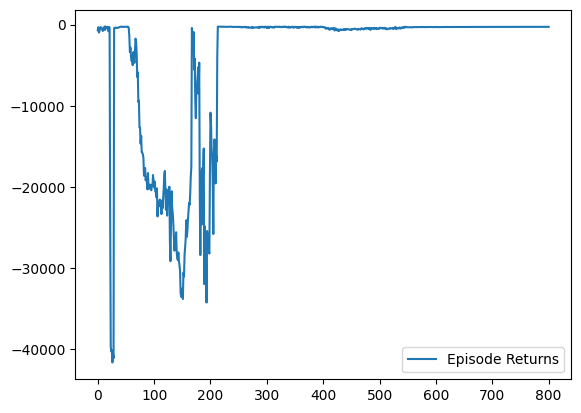

In [16]:
# Plot learning
fig, ax = plt.subplots(1, 1)

xx = np.arange(len(all_returns))

ax.plot(xx, all_returns, label="Episode Returns")

ax.legend()

plt.show()